In [1]:
'''
author: Felix Hol
date: 2019 July 17
content: using tracks of mosquitoes get parameters of trajectories (time, movement stats, belly size)
'''

import numpy as np
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') ### this is a workaround for a bug when running on macOS, may not be necessary anymore
import matplotlib.pyplot as plt
import os
import itertools as it
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import skimage
from skimage import data, io, util
from skimage.feature import (canny, match_descriptors, peak_local_max, match_template, corner_peaks, corner_harris, plot_matches, BRIEF)
from skimage.color import rgb2gray
from skimage.draw import circle
from skimage.measure import label, regionprops
from skimage.morphology import binary_dilation, erosion, dilation, opening, binary_closing, closing, white_tophat, remove_small_objects, disk, black_tophat, skeletonize, convex_hull_image
from scipy import ndimage as ndi
import scipy
import trackpy as tp
import pylab
import math
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime
from tqdm import tnrange
import pickle
import glob
import cv2 as cv

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
dataDir = '/Volumes/Fe_ssd02/biteData/190625_KPPTN/01'
saveDir = '/Users/felix/Documents/mosquitoes/mosquitoData/biteData/aegypti/190625_KPPTN/crops'
frames = pims.ImageSequence(dataDir+'/*.tiff', as_grey=True)

In [3]:
len(frames)

21627

In [4]:
t = pickle.load(open('/Users/felix/Documents/mosquitoes/mosquitoData/biteData/aegypti/190625_KPPTN/190625_KPPTN_01_ROItracks.pkl', 'rb'))

In [5]:
t.head()

y           x  frame  particle
0    0.000000    0.000000    0.0       0.0
1  133.925222  660.855885  809.0       1.0
2  136.908596  681.481511  810.0       1.0
3  127.207769  679.469832  811.0       1.0
4  121.247623  683.551426  812.0       1.0

In [84]:
def cropMosAndBelly02(p, t):
    frameWidth = 2048
    frameHeigth = 2048
    ROIwidth = 550
    ROIheigth = 550
    halfROIwidth = ROIwidth / 2
    halfROIheigth = ROIheigth / 2

    tP = t.loc[t['particle'] == p]
    s = np.linspace(0, 2*np.pi, 400)
    bellySizeRR = np.empty([0, 0])
    snakeArea = np.empty([0, 0])
    for index, row in tP.iterrows():
        if row['x'] < halfROIwidth:
            x_start = 0
            x_stop = ROIwidth
            newX = row.x
        elif row['x'] + halfROIwidth > frameWidth:
            x_start = frameWidth - ROIwidth
            x_stop = frameWidth
            newX = halfROIwidth + (halfROIwidth - (frameWidth - row.x))
        else:
            x_start = row['x'] - halfROIwidth
            x_stop = row['x'] + halfROIwidth
            newX = halfROIwidth
        if row['y'] < halfROIwidth:
            y_start = 0
            y_stop = ROIwidth
            newY = row.y
        elif row['y'] + halfROIwidth > frameWidth:
            y_start = frameWidth - ROIwidth
            y_stop = frameWidth
            newY = halfROIheigth + (halfROIheigth - (frameHeigth - row.y))
        else:
            y_start = row['y'] - halfROIwidth
            y_stop = row['y'] + halfROIwidth
            newY = halfROIheigth
        currFrame = frames[row['frame']]
        currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
        skimage.io.imsave("crop_p" + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png", currROI)

        x = newX + 100*np.cos(s)
        y = newY + 100*np.sin(s)
        init = np.array([x, y]).T
        imBTH = skimage.morphology.black_tophat(currROI, disk(4))
        imBT = imBTH > 7
        # imBTE = erosion(imBT, disk(1))
        # imBTED = binary_dilation(imBT, disk(2))
        # imBTES = remove_small_objects(imBTED, min_size=200)
        F = np.copy(currROI)
        F[F > np.median(currROI)] = np.median(currROI)
        F[imBT] = np.median(F)
        F[currROI>70] = np.median(F)
        F = skimage.filters.gaussian(F, 4)
        snake = skimage.segmentation.active_contour(F*20, init, alpha=0.5, beta=8, gamma=0.001, w_edge=1, w_line=0)
        snakeD = np.expand_dims(snake, axis=1)
        rotRect = cv.minAreaRect(snakeD.astype(int))
    #         bellySizeRR = np.min(rotRect[1])
        bellySizeRR = np.append(bellySizeRR, np.min(rotRect[1]))
        snakeArea = np.append(snakeArea, cv.contourArea(snakeD.astype(int)))
    return bellySizeRR, snakeArea

In [85]:
def analyzeMos(j, t):
    mosData = pd.DataFrame(columns=['p','totDist','totTime','meanSpeed','bellyWExp','bellyWidthT', 'bellyAExp', 'bellyAreaT'])
    p = t.loc[t['particle'] == j]
    d = 0
    for i in range(1, len(p) - 2):
        d = d + math.sqrt((p.iloc[i + 1].x - p.iloc[i].x) ** 2 + (p.iloc[i + 1].y - p.iloc[i].y) ** 2)
    D = d
    V = D / (len(p) - 2)
    [bellyWidth, bellyArea] = cropMosAndBelly02(j, t)
    initSizeW = np.nanmean(bellyWidth[0:15])
    bellyWidthExpansion = np.percentile(bellyWidth / initSizeW, 95)
    initSizeA = np.nanmean(bellyArea[0:15])
    bellyAreaExpansion = np.percentile(bellyArea / initSizeA, 95)
    
    mosData = mosData.append({'p': j,
                   'totDist': D,
                    'totTime': len(p),
                   'meanSpeed': V,
                   'bellyWExp': bellyWidthExpansion,
                    'bellyWidthT': bellyWidth, 
                    'bellyAExp': bellyAreaExpansion,
                    'bellyAreaT': bellyArea},
                    ignore_index=True)
    mosData.to_pickle('/Users/felix/Documents/mosquitoes/mosquitoData/biteData/aegypti/190625_KPPTN/mosDataTest' + str(j) + '.pkl')
  

In [95]:
tFilt.particle.unique()

array([  1.,   5.,   6.,   9.,  12.,  13.,  15.,  16.,  21.,  23.,  27.,
        34.,  35.,  36.,  38.,  40.,  42.,  43.,  45.,  46.,  49.,  54.,
        55.,  56.,  57.,  60.,  63.,  68.,  69.,  70.,  71.,  74.,  76.,
        77.,  80.,  84.,  88.,  92.,  93.,  96., 102., 103., 108.])

In [98]:
os.chdir(saveDir)

# mosToAnalyze = tFilt.particle.unique()
mosToAnalyze = [77.0]



num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(analyzeMos)(i, t) for i in mosToAnalyze)

[None]

In [216]:
pklList = glob.glob('/Users/felix/Documents/mosquitoes/mosquitoData/biteData/aegypti/190625_KPPTN/mosData*.pkl')

mosDataAll = pd.DataFrame(columns=['p','totDist','totTime','meanSpeed','bellyWExp','bellyWidthT', 'bellyAExp', 'bellyAreaT'])

for i in pklList:
    mD = pd.read_pickle(i)
    mosDataAll = mosDataAll.append(mD, ignore_index=True)

In [135]:
mosDataAll.dtypes

p              float64
totDist        float64
totTime          int64
meanSpeed      float64
bellyWExp      float64
bellyWidthT     object
bellyAExp      float64
bellyAreaT      object
dtype: object

In [134]:
mosDataAll["totTime"] = pd.to_numeric(mosDataAll["totTime"])

In [125]:
mosDataAll.head()

p      totDist totTime  meanSpeed  bellyWExp  \
0  71.0  1113.890854     122   9.282424   1.188817   
1  34.0  1638.110392     141  11.784967   1.528557   
2   1.0    53.402005      40   1.405316   1.161274   
3  68.0  2102.853611    4063   0.517817   1.531016   
4  55.0   148.967033      15  11.459003   1.145669   

                                         bellyWidthT  bellyAExp  \
0  [34.17289352416992, 34.68918991088867, 34.5112...   1.100254   
1  [26.01508140563965, 31.55946922302246, 31.5019...   1.061107   
2  [28.905933380126953, 43.00578689575195, 44.525...   1.142678   
3  [23.0, 27.972259521484375, 32.31113815307617, ...   1.590663   
4  [25.28009605407715, 30.584476470947266, 37.964...   1.177290   

                                          bellyAreaT  
0  [4083.0, 3673.5, 4149.5, 3958.0, 3984.0, 4110....  
1  [2118.0, 3524.0, 3622.0, 3750.0, 3736.5, 3808....  
2  [2273.5, 3037.5, 3256.0, 3268.5, 3308.0, 3107....  
3  [1318.0, 2611.5, 3494.0, 3801.5, 3528.0, 3501....  
4  [1594.0, 1809.0, 2211.0, 1937.5, 2501.5, 2148....

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b181278>,
      dtype=object)

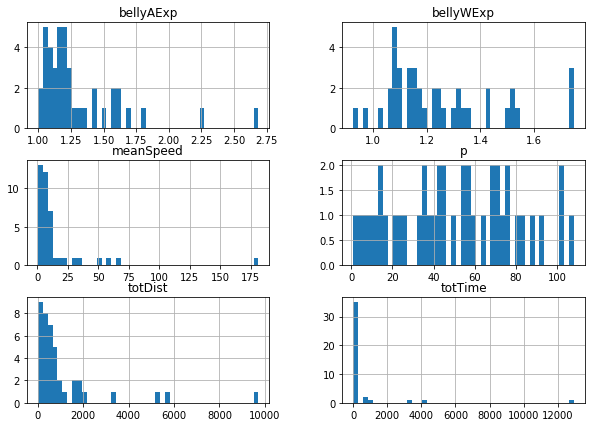

In [139]:
mosDataAll.hist( figsize=(10,7), bins=45)

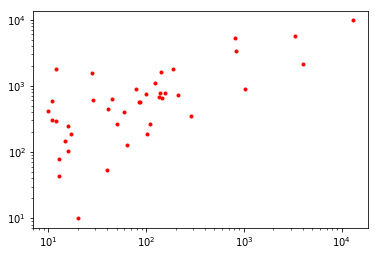

In [146]:
plt.loglog(mosDataAll.totTime, mosDataAll.totDist, '.r')

In [77]:
os.chdir(saveDir)
# mosToAnalyze = tFilt.particle.unique()
mosToAnalyze = [13.0]
mosData = pd.DataFrame(columns=['p','totDist','totTime','meanSpeed','bellyWExp','bellyWidthT', 'bellyAExp', 'bellyAreaT'])

for j in  mosToAnalyze:
    p = t.loc[t['particle'] == j]
    d = 0
    for i in range(1, len(p) - 2):
        d = d + math.sqrt((p.iloc[i + 1].x - p.iloc[i].x) ** 2 + (p.iloc[i + 1].y - p.iloc[i].y) ** 2)
    D = d
    V = D / (len(p) - 2)
    [bellyWidth, bellyArea] = cropMosAndBelly02(j, t)
#     bellySizeC = bellyWidth
#     bellySizeC[bellySizeC < 15] = np.nan
#     bellySizeC[bellySizeC > 70] = np.nan
    initSizeW = np.nanmean(bellyWidth[0:15])
    bellyWidthExpansion = np.percentile(bellyWidth / initSizeW, 95)
    initSizeA = np.nanmean(bellyArea[0:15])
    bellyAreaExpansion = np.percentile(bellyArea / initSizeA, 95)
    
    mosData = mosData.append({'p': j,
                   'totDist': D,
                    'totTime': len(p),
                   'meanSpeed': V,
                   'bellyWExp': bellyWidthExpansion,
                    'bellyWidthT': bellyWidth, 
                    'bellyAExp': bellyAreaExpansion,
                    'bellyAreaT': bellyArea},
                    ignore_index=True)
#     mosData.to_pickle('/Users/felix/Documents/mosquitoes/mosquitoData/biteData/aegypti/190625_KPPTN/mosDataTest' + str(j) + '.pkl')
    

2554.0
2555.0
2556.0
2557.0
2561.0
2562.0
2563.0
2564.0
2565.0
2566.0
2567.0
2568.0
2569.0
2570.0
2571.0
2572.0


In [78]:
mosData.head()

p     totDist totTime  meanSpeed  bellyWExp  \
0  13.0  248.062341      16  17.718739   1.102707   

                                         bellyWidthT  bellyAExp  \
0  [35.030887603759766, 39.14618682861328, 37.684...   1.099754   

                                          bellyAreaT  
0  [3953.0, 4073.5, 3934.0, 3817.5, 3405.0, 3232....

In [156]:
color=plt.cm.rainbow(np.linspace(0,1,len(mosDataAll)))

(2000, 8000)

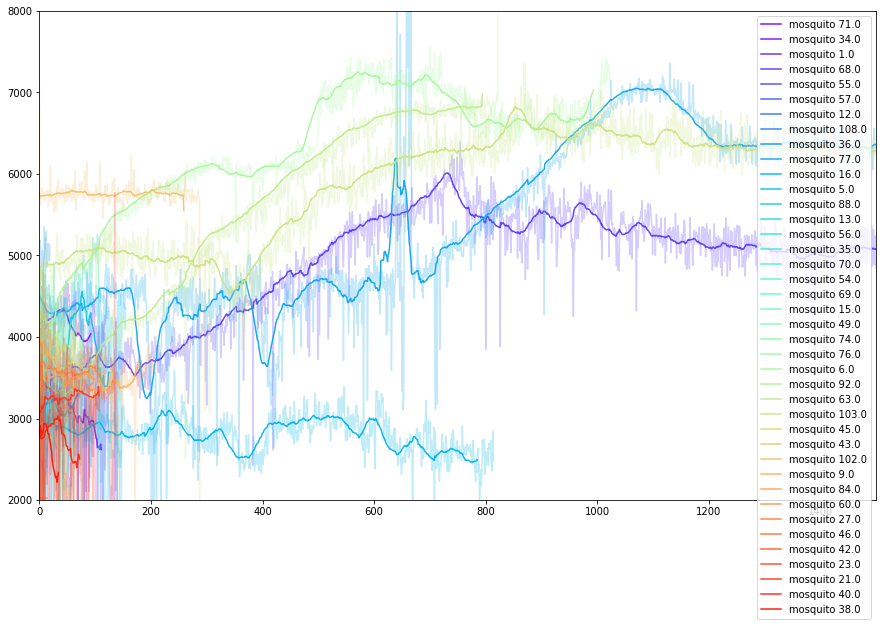

In [240]:
plt.figure(figsize=(15,9))

color=iter(plt.cm.rainbow(np.linspace(0,1, len(mosDataAll))))

N = 30

for i in range(1, len(mosDataAll)):
    c=next(color)
    bellySizeC = np.copy(mosDataAll.iloc[i-1].bellyAreaT)
#     bellySizeC[bellySizeC < 15] = np.nan
#     bellySizeC[bellySizeC > 70] = np.nan
#     initSize = np.nanmean(bellySizeC[0:35])
    bellySizeS = np.convolve(bellySizeC, np.ones((N,))/N, mode='valid')
    plt.plot(bellySizeC , c=c, alpha=0.25)
    plt.plot(bellySizeS , c=c, alpha=0.95, label='mosquito %s' % mosDataAll.iloc[i-1].p)
    
plt.legend()
plt.xlim([0,1500])
plt.ylim([2000, 8000])


# bellySizeC = bellySizeRRp
# bellySizeC[bellySizeC < 15] = np.nan
# bellySizeC[bellySizeC > 70] = np.nan
# initSize = np.nanmean(bellySizeC[0:35])

# plt.plot(t[0:-Nmin1], bellySizeRRp[0:-Nmin1] / initSize, 'm', alpha=0.3, label='_nolegend_')
# bellySizeS = np.convolve(bellySizeC, np.ones((N,))/N, mode='valid')
# plt.plot(t[int(N/2):-NminHalf], bellySizeS / initSize, 'm', linewidth=3)

In [233]:
mosDataAll.iloc[i-1].totTime > 20

True

(2000, 8000)

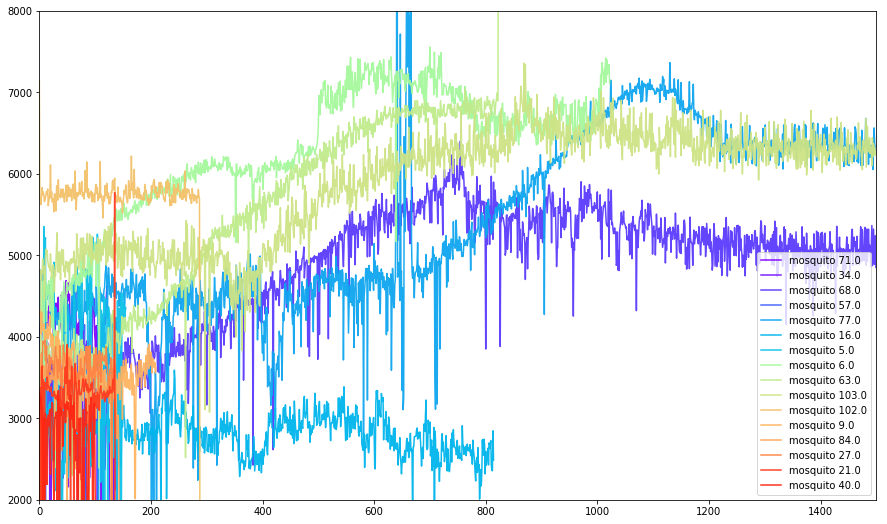

In [238]:
plt.figure(figsize=(15,9))

color=iter(plt.cm.rainbow(np.linspace(0,1, len(mosDataAll))))

for i in range(1, len(mosDataAll)):
    c=next(color)
    if mosDataAll.iloc[i-1].totTime > 100:
        mosDataAll.iloc[i-1].bellyAreaT
        plt.plot(mosDataAll.iloc[i-1].bellyAreaT, c=c, alpha=0.95, label='mosquito %s' % mosDataAll.iloc[i-1].p)

plt.legend()
plt.xlim([0,1500])
plt.ylim([2000, 8000])


(2000, 8000)

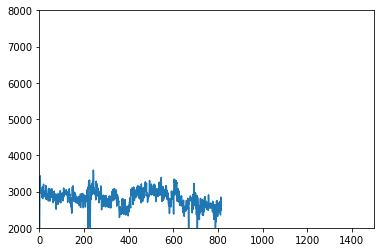

In [231]:
plt.plot( np.concatenate(mosDataAll.loc[mosDataAll['p'] == 16.0].bellyAreaT.values).astype(None))

# plt.xlim([0,1500])
# plt.ylim([20, 70])
plt.xlim([0,1500])
plt.ylim([2000, 8000])

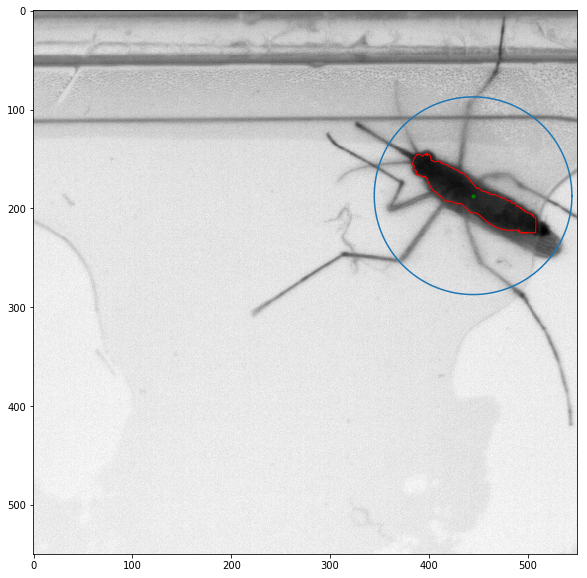

KeyboardInterrupt: 

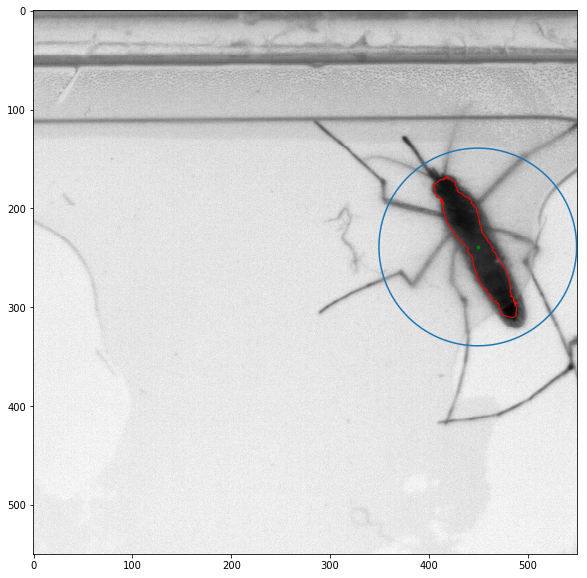

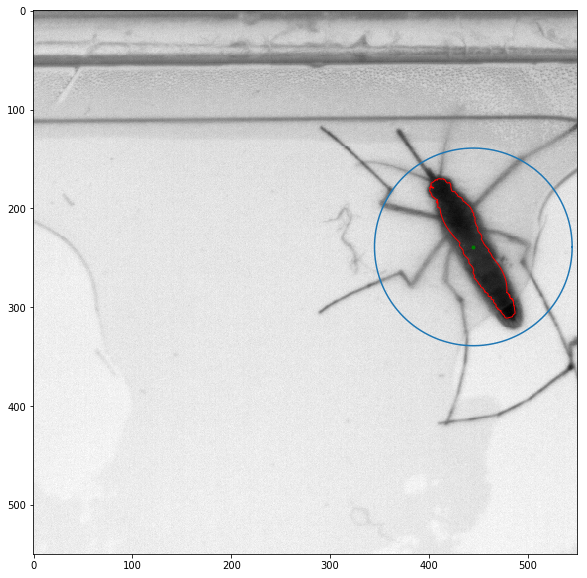

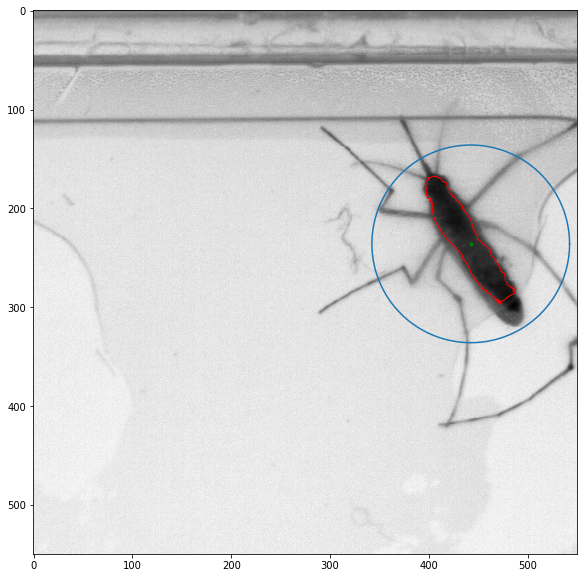

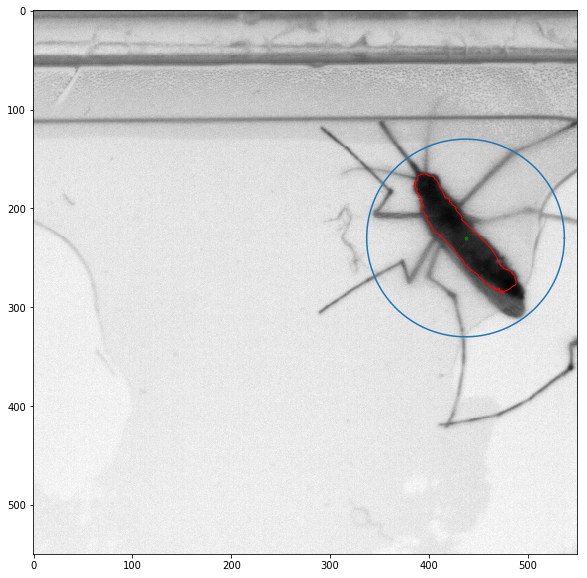

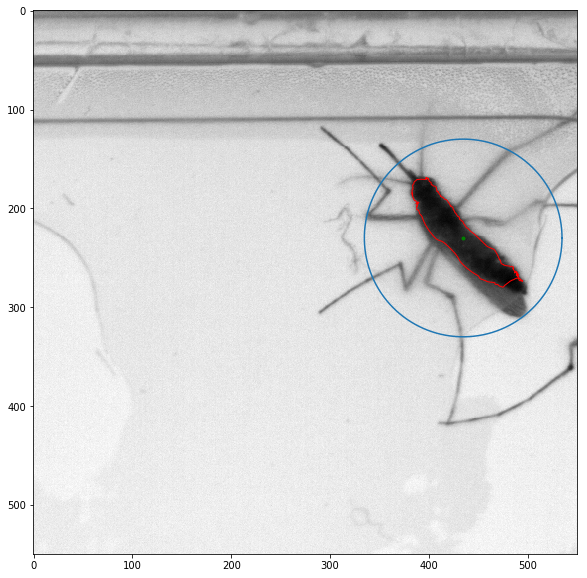

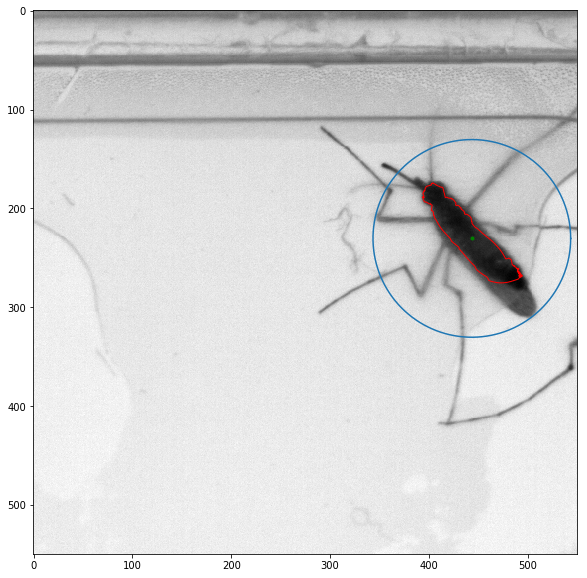

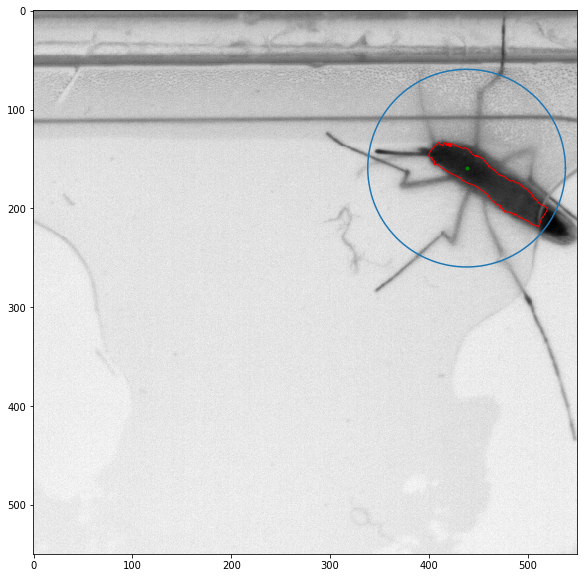

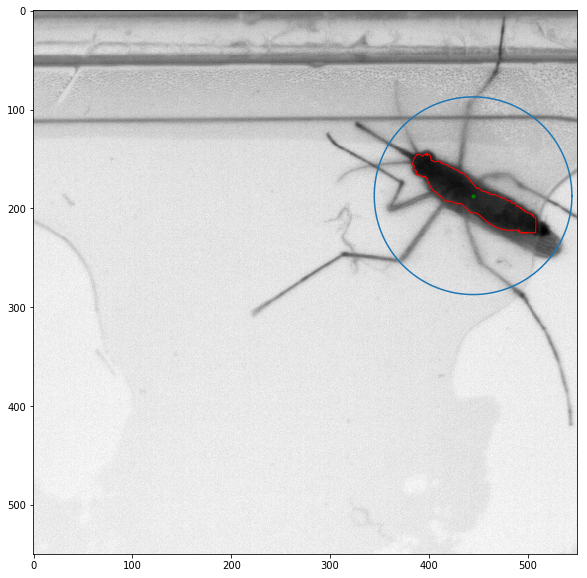

In [65]:
from IPython import display
import pylab as pl


frameWidth = 2048
frameHeigth = 2048
ROIwidth = 550
ROIheigth = 550
halfROIwidth = ROIwidth / 2
halfROIheigth = ROIheigth / 2

tP = t.loc[t['particle'] == 60.0]
s = np.linspace(0, 2*np.pi, 400)
bellySizeRR = np.empty([0, 0])
snakeArea = np.empty([0, 0])
for index, row in tP.iterrows():
    if row['x'] < halfROIwidth:
        x_start = 0
        x_stop = ROIwidth
        newX = row.x
    elif row['x'] + halfROIwidth > frameWidth:
        x_start = frameWidth - ROIwidth
        x_stop = frameWidth
        newX = halfROIwidth + (halfROIwidth - (frameWidth - row.x))
    else:
        x_start = row['x'] - halfROIwidth
        x_stop = row['x'] + halfROIwidth
        newX = halfROIwidth
    if row['y'] < halfROIwidth:
        y_start = 0
        y_stop = ROIwidth
        newY = row.y
    elif row['y'] + halfROIwidth > frameWidth:
        y_start = frameWidth - ROIwidth
        y_stop = frameWidth
        newY = halfROIheigth + (halfROIheigth - (frameHeigth - row.y))
    else:
        y_start = row['y'] - halfROIwidth
        y_stop = row['y'] + halfROIwidth
        newY = halfROIheigth
    currFrame = frames[row['frame']]
    currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
#     skimage.io.imsave("crop_p" + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png", currROI)
    print(row.frame)

    x = newX + 100*np.cos(s)
    y = newY + 100*np.sin(s)
    init = np.array([x, y]).T
    imBTH = skimage.morphology.black_tophat(currROI, disk(4))
    imBT = imBTH > 7
    # imBTE = erosion(imBT, disk(1))
    # imBTED = binary_dilation(imBT, disk(2))
    # imBTES = remove_small_objects(imBTED, min_size=200)
    F = np.copy(currROI)
    F[F > np.median(currROI)] = np.median(currROI)
    F[imBT] = np.median(F)
    F[currROI>70] = np.median(F)
    F = skimage.filters.gaussian(F, 4)
    snake = skimage.segmentation.active_contour(F*20, init, alpha=0.5, beta=8, gamma=0.001, w_edge=1, w_line=0)
    snakeD = np.expand_dims(snake, axis=1)
    rotRect = cv.minAreaRect(snakeD.astype(int))
#         bellySizeRR = np.min(rotRect[1])
    bellySizeRR = np.append(bellySizeRR, np.min(rotRect[1]))
    snakeArea = np.append(snakeArea, cv.contourArea(snakeD.astype(int)))

    plt.figure(figsize=(10,10))
    plt.imshow(currROI, cmap=plt.cm.gray)
    plt.plot(init[:, 0], init[:, 1])
    plt.plot(snake[:, 0], snake[:, 1], '-r', lw=1)
    plt.plot(newX, newY, '.g', markersize=6)
    display.clear_output(wait=True)
    display.display(pl.gcf())